In [5]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
from pathlib import Path

project_root = Path(__file__).resolve().parents[2] if "__file__" in globals() else Path().resolve().parents[1]
sys.path.append(str(project_root))

from paths import DATA_DIR


# COVID-19 Effects on Bike Traffic in Paris

In this notebook, we explore how different COVID-19 features (lockdowns, stringency index, incidence rates) relate to cyclist traffic in Paris.


In [6]:
data = pd.read_parquet(DATA_DIR / "train.parquet")
data_test = pd.read_parquet(DATA_DIR / "final_test.parquet")

# Aggregate daily bike counts
data_daily = (
    data.groupby(pd.Grouper(freq="1D", key="date"))["log_bike_count"]
    .sum()
    .reset_index()
)

data_daily.head()


,date,log_bike_count
0,2020-09-01,4755.779693
1,2020-09-02,4920.149032
2,2020-09-03,4994.609658
3,2020-09-04,5090.042169
4,2020-09-05,4715.563929


## Approach 1 — Lockdown Periods

We first test a simple binary feature: `Covid-19 = 1` during official lockdowns, `0` otherwise.


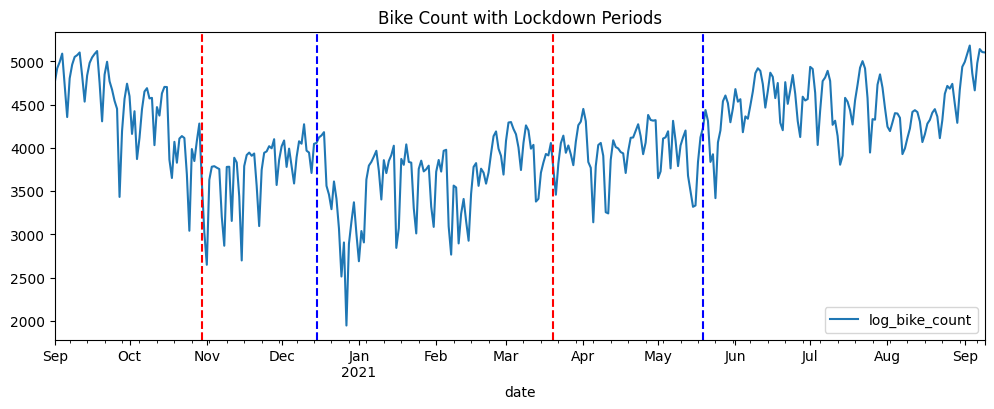

In [7]:
expanded_data = data.copy()

lockdown_periods = [
    ("2020-10-30", "2020-12-15"),
    ("2021-03-20", "2021-05-19"),
]

expanded_data["Covid-19"] = 0
for start, end in lockdown_periods:
    expanded_data["Covid-19"] |= expanded_data["date"].between(start, end).astype(int)

expanded_data_daily = (
    expanded_data.groupby(pd.Grouper(freq="1D", key="date"))["log_bike_count"]
    .sum()
    .reset_index()
)

# Plot with lockdown markers
fig, ax = plt.subplots(figsize=(12, 4))
expanded_data_daily.plot(x="date", y="log_bike_count", ax=ax)

for start, end in lockdown_periods:
    ax.axvline(pd.to_datetime(start), color="red", linestyle="--", label="Lockdown start")
    ax.axvline(pd.to_datetime(end), color="blue", linestyle="--", label="Lockdown end")

plt.title("Bike Count with Lockdown Periods")
plt.show()


## Approach 2 — Stringency Index

We enrich the dataset with the Oxford COVID-19 Government Response Tracker's **Stringency Index** for France.
This provides a more nuanced measure of restrictions.


/var/folders/bn/bvffp5151hvf872qg5mg_l9w0000gn/T/ipykernel_27554/2533022764.py:1: DtypeWarning: Columns (2,3,44,45) have mixed types. Specify dtype option on import or set low_memory=False.
  covid_index = pd.read_csv(DATA_DIR / "Covid_19_Index.csv")


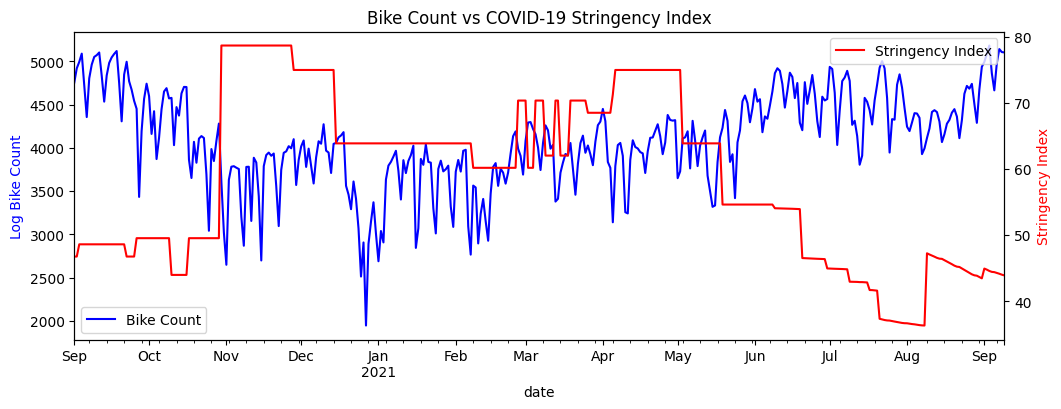

In [8]:
covid_index = pd.read_csv(DATA_DIR / "Covid_19_Index.csv")

covid_index["date"] = pd.to_datetime(covid_index["Date"], format="%Y%m%d")
covid_index = (
    covid_index.query("CountryName == 'France'")
    .query(f"date >= '{data_daily['date'].min()}' and date <= '{data_daily['date'].max()}'")
)

# Plot bike count vs stringency
fig, ax1 = plt.subplots(figsize=(12, 4))

data_daily.plot(x="date", y="log_bike_count", ax=ax1, color="blue", label="Bike Count")
ax1.set_ylabel("Log Bike Count", color="blue")

ax2 = ax1.twinx()
covid_index.plot(x="date", y="StringencyIndex_Average", ax=ax2, color="red", label="Stringency Index")
ax2.set_ylabel("Stringency Index", color="red")

plt.title("Bike Count vs COVID-19 Stringency Index")
plt.show()


We also compare the **Stringency Index** with the **Containment Health Index**, which measures similar but not identical policies.


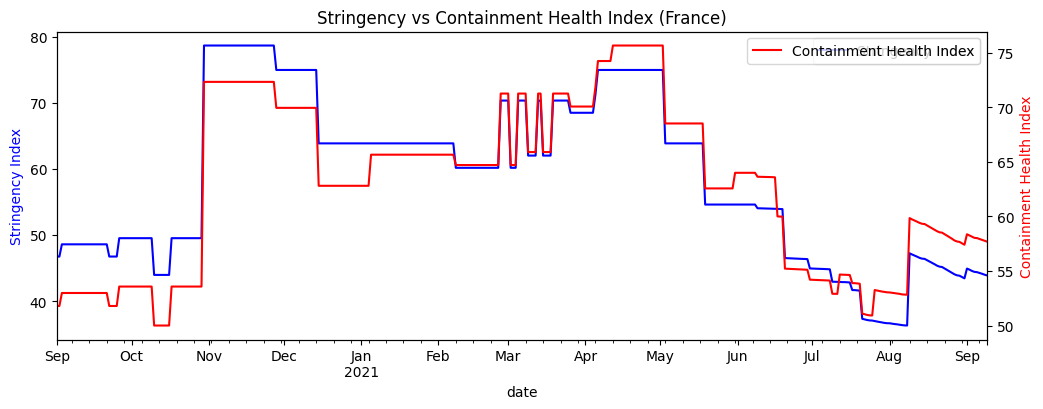

In [9]:
fig, ax1 = plt.subplots(figsize=(12, 4))

covid_index.plot(x="date", y="StringencyIndex_Average", ax=ax1, color="blue", label="Stringency Index")
ax1.set_ylabel("Stringency Index", color="blue")

ax2 = ax1.twinx()
covid_index.plot(x="date", y="ContainmentHealthIndex_Average", ax=ax2, color="red", label="Containment Health Index")
ax2.set_ylabel("Containment Health Index", color="red")

plt.title("Stringency vs Containment Health Index (France)")
plt.show()


## Approach 3 — Epidemiological Indicators

Finally, we test whether epidemiological indicators like **R (reproduction number)** or **incidence rate** are correlated with bike usage.


/var/folders/bn/bvffp5151hvf872qg5mg_l9w0000gn/T/ipykernel_27554/3890808991.py:1: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  covid_epidemio = pd.read_csv(DATA_DIR / "Covid_19.csv")


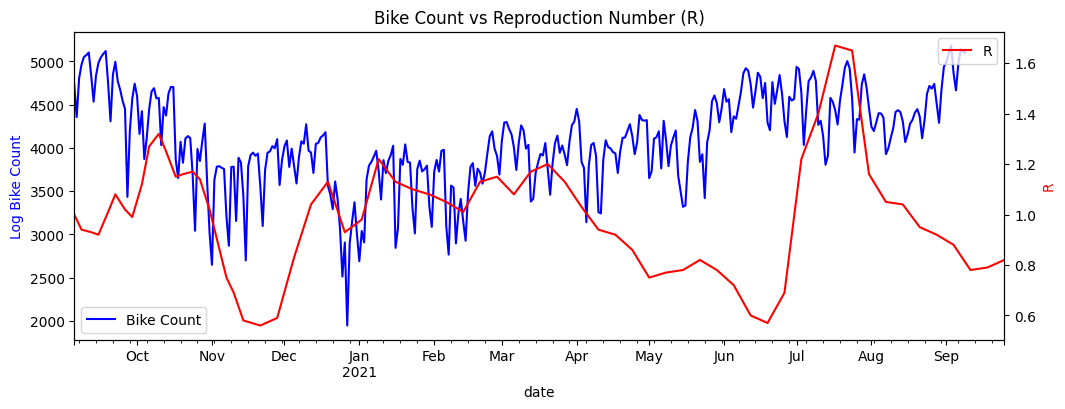

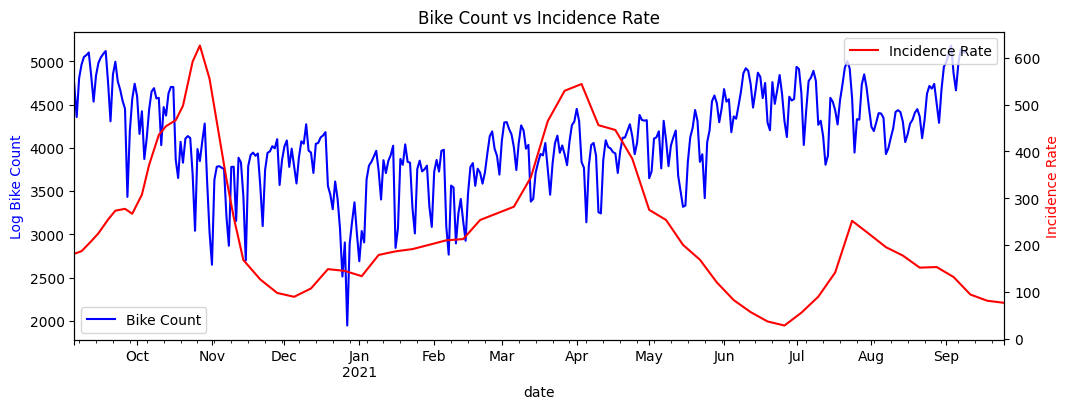

In [10]:
covid_epidemio = pd.read_csv(DATA_DIR / "Covid_19.csv")

covid_epidemio["date"] = pd.to_datetime(covid_epidemio["date"])
covid_epidemio = (
    covid_epidemio.query("dep == 75 and date > '2020-09-01' and date < '2021-10-01'")
    .dropna(subset=["R"])
)

# Plot Bike Count vs R
fig, ax1 = plt.subplots(figsize=(12, 4))
data_daily.plot(x="date", y="log_bike_count", ax=ax1, color="blue", label="Bike Count")
ax1.set_ylabel("Log Bike Count", color="blue")

ax2 = ax1.twinx()
covid_epidemio.plot(x="date", y="R", ax=ax2, color="red", label="R")
ax2.set_ylabel("R", color="red")

plt.title("Bike Count vs Reproduction Number (R)")
plt.show()

# Plot Bike Count vs incidence rate
fig, ax1 = plt.subplots(figsize=(12, 4))
data_daily.plot(x="date", y="log_bike_count", ax=ax1, color="blue", label="Bike Count")
ax1.set_ylabel("Log Bike Count", color="blue")

ax2 = ax1.twinx()
covid_epidemio.plot(x="date", y="tx_incid", ax=ax2, color="red", label="Incidence Rate")
ax2.set_ylabel("Incidence Rate", color="red")

plt.title("Bike Count vs Incidence Rate")
plt.show()


## Conclusion

- **Binary lockdown flags** are too coarse and don’t capture nuances.  
- **Stringency Index** is a better feature — smooth, interpretable, correlates with mobility.  
- **R & incidence rate** are noisy and don’t show clear correlation with bike traffic.  

➡️ For modeling, we keep **Stringency Index** as the main COVID-19 feature.
